In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity

$\chi$ is the spin and is distributed uniformly, betweeen 0 and 1. The mass $M$ is distributed Gaussianly with given $\mu$ and $\sigma$.
Let's create some samples.

[Text(0.5, 0, '$M$'), Text(0, 0.5, 'p($M$)'), Text(0.5, 1.0, '$M$ histogram')]

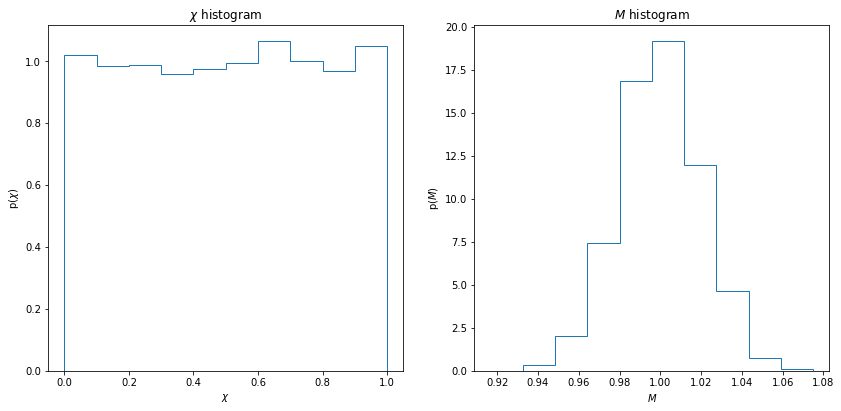

In [2]:
Nsamples = 10000

chi = np.random.uniform(0, 1, Nsamples)

mean = 1
sigma = 0.02
mass = np.random.normal (mean, sigma, Nsamples)

fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(221)
ax.hist (chi, histtype='step', density = True)
ax.set(xlabel = '$\chi$', ylabel = 'p($\chi$)', title = '$\chi$ histogram')

ax = fig.add_subplot(222)
ax.hist(mass, histtype='step', density = True)
ax.set(xlabel = '$M$', ylabel = 'p($M$)', title = '$M$ histogram')

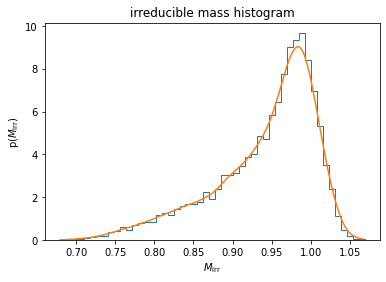

In [6]:
def get_M_irr (chi, mass):
    m_irr = mass * np.sqrt(0.5 * (1 + np.sqrt(1 - np.power(chi, 2))))
    return m_irr

m_irr = get_M_irr(chi, mass)

_ = fancyhist(m_irr, bins="freedman", histtype="step",density=True)
plt.title('irreducible mass histogram')
plt.xlabel('$M_\mathrm{irr}$')
plt.ylabel('p($M_\mathrm{irr}$)')

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(m_irr[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

m_irr.sort()
gauss_pdf = kde_sklearn(m_irr,bandwidth=0.01,kernel="gaussian")
plt.plot(m_irr, gauss_pdf) 

KstestResult(statistic=0.2476, pvalue=1.8959535627316808e-269)


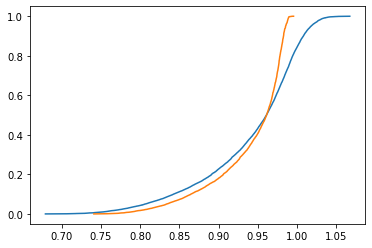

In [15]:
cdf = np.linspace(0, 1, Nsamples)
plt.plot(m_irr, cdf)

f = m_irr/mass
f.sort()
plt.plot(f, cdf)

print(sc.ks_2samp(m_irr, f))

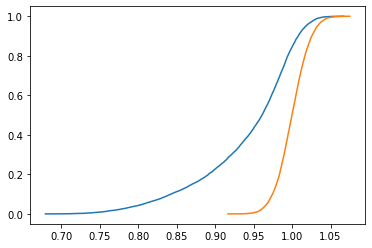

In [11]:
cdf = np.linspace(0, 1, Nsamples)
plt.plot(m_irr, cdf)

mass.sort()
plt.plot(mass, cdf)